In [54]:
import sys
import hashlib
if sys.version_info < (3, 6):
    import sha3
import datastructures as DS
reload(DS)

GD = {}    #giant dictionary
data= []
class DLS:
    def __init__(self):
        self.debug= True
        global GD  
        GD = {}
        global data
        pass
    def makedoc(self,xdict,key,nkey):
        skey,snkey = str(int(key)),str(int(nkey))
        hkey = hashlib.sha224(skey+snkey).hexdigest()
        return {"_id":hkey,
                "key":key,
                "nkey":nkey,
                'rvalue':['r\'','r\''], #root value
                "type":'lut',
                "value_ypairs":xdict[key]} #r' is the root of the tree with leaf nodes pairs of y ords.
    
    #return a dictionary object which is a doc in a collection in a db.
    def Get(self,cid,sk): #will get the record, 3 types
        hkey=self.h(cid,sk)
        return dbcollection.find_one({"_id": hkey})

    #it inserts item in mongodb
    def Put(self,key,nkey):
        newdoc=self.makedoc(xdict,key,nkey)
        dbcollection.insert_one(newdoc) #do get doc before
    
    def put(self,key,record):
        #a record can be [pcid,pkey] or structure S or a hash, pcid,pkey = parent collection id, parent key
        if type(record) is dict:
            GD[key] = record #if mongodb is used, get a record with column "key"=key
        elif isinstance(record, DS.St):
            GD[key] = record.castToDict()
        else:
            GD[key] = record
        
        #NOTE:
        ''' 
            for a python dictionary, does not matter if record exists for (key,record).
            for mongodb, if (key,record) exists: do-update, else do-insert
        '''
        
    def delete(key):
        try:
            del GD[key]
        except Exception,e:
            print(str(e))
        #none
        '''
        try:
            db.collection_c.delete_many({"_id":key}) #which db,collection,
            print '\nDeletion successful\n' 
        except Exception, e:
            print str(e)
        '''
    def get(self,key):  
        #will get the record of 3 differnt types.
        return GD[key]
    
    def h(self,*args):
        s = hashlib.sha3_224()
        for p in args:
            s.update(str(p))
        return s.hexdigest()[0:8]
        
    def Init(self):
        cid = self.h(1,0,0) #id of main collection with parent 0 and key 0
        self.put(cid,[0,0]) #even main collection has an entry
        self.put(self.h(cid,0,0),0) #initialize root of main collection to zero
        return cid
        
    def InsertFirstKey(self,cid,k,t):#cid,key,type
        oldhash = self.get(self.h(cid,0,0))
        if oldhash == 0:
            newhash = self.h(k,k,0,t)
            S = DS.St()
            S.key = k
            S.nkey = k;e
            S.val = 0;
            S.type_ = t;
            S.x = 0;
            S.y = 0;
            S.colid = cid; #collection id.
            S = S.castToDict()#cast to dict obj
            self.put(self.h(cid,k),S)
            self.put(self.h(cid,0,0), newhash)
            [p_cid,p_key] = self.get(cid) #see if cid has parents
            if p_cid != 0: #has parent
                self.Recursive(p_cid,p_key,oldhash,newhash)
            
    def CreateCollection(self,cid,k): #parent cid, parent key
        #a new colleciton is created under any parent collection 'cid', leaf structure S with key 'k'
        Sdic = self.get(self.h(cid,k)) 
        S = DS.St(dic=Sdic) #coz get returns dic type,
        if S.val == 0: #value os zero so we can initialize collection by adding the record
            childcid = self.h(1,cid,k)
            self.put(childcid,[cid,k]) #new collection created
            self.put(self.h(childcid,0,0),0) #initializing root of the childcid hashes.
            return childcid
    
    def InsertKey(self,cid,sk,k):#sk is the key that is split to insert key k
        import copy
        Sdic = self.get(self.h(cid,sk)) #cast to S obj
        S = DS.St(dic=Sdic)
        SN = copy.deepcopy(S);#new item
        skp = S.nkey
        if not ((k < k < skp) or (k > sk >= skp) or (sk >= skp > k)):
            return #new key k is not enclosed by sk, sk
        S.nkey = k; SN.key = k
        if SN.type_ == 0: 
            SN.val = 0
            
        ox = S.x; 
        oy = S.y #old x, y values of item sk, it's going to be pulled down.
        oldhash_sk = self.get(self.h(cid,ox,oy))
        newhash_sk = self.h(S.key, S.nkey, S.val, SN.type_) #as S.nkey is now different
        hash_k = self.h(SN.key, SN.nkey,SN.val, SN.type_) #hash of new item
        
        #pulling down both items
        S.x = 2*ox; 
        SN.x = 2*ox+1;  
        S.y = SN.y = oy + 1
        
        #write back items         
        self.put(self.h(cid,sk),S)#cast S and SN objects,rep
        self.put(self.h(cid,k), SN) #new-1
        
        #store new hashes
        self.put(self.h(cid,S.x,S.y),newhash_sk)
        self.put(self.h(cid,SN.x,SN.y),hash_k) 
        
        #compute parent
        newparent = self.h(newhash_sk,hash_k)
        self.put(self.h(cid,ox,oy),newparent) #oldhash_sk was the original value at ox, oy
        [oldroot, newroot] = self.UpdateHashes(cid,ox,oy,oldhash_sk,newparent)
        [p_cid, p_key] = self.get(cid)
        if p_cid != 0:
            self.Recursive(p_cid,p_key, oldroot,newroot)
            
        
    def UpdateHashes(self,cid,x,y,old,new):
        if self.debug: print("updating hashes."), cid,x,y,old,new
        #in collection cid, hash x, y is modified from old to new
        #this functions updates all parent hashes accordingly
        oldroot = self.get(self.h(cid,0,0)) #this is the root of the collection that will be 
        #changed by this function.#along with all hashes on the way to the root
        
        self.put(self.h(cid,x,y),new)#first we will set the new leaf hash;this is duplicate fun.
        
        xc = x;#current values of x and y as we move up the tree.
        yc = y;
        ch = new #current hash. we will keep hash extending with complementary nodes
        
        while yc > 0:
            if (xc % 2 == 1): #xc is odd, the sibiling hash is to the left)
                sh = self.get(self.h(cid,xc-1,yc));#sh is siblihg hash
                ch = self.h(sh,ch) #current hash ch, left or right information
            else:
                #sc is even so sibling is to the right
                sh = self.get(self.h(cid,xc+1), yc)
                ch  = self.h(ch,sh)
            #end el
            yc = y-1 #climb up
            xc = xc >> 1 #dividing by 2, move left/right
            
            #@TODO: collect all (sibling hashes) complementary hashes (comp.nodes) for creating certs
            ##also need to add things to collect all complementary hashes to help create certificates
            
            self.put(self.h(cid,xc,yc), ch) #update, this is the new current hash
            
        #endwhile
        #when wile loop is done, the root should be set    
        return oldroot, ch #ch is the new root.
        
    def Recursive(self,cid, key,old, new): #old hash, new hash
        while cid !=0:
            if self.debug:print("recursive"),self.h(cid,key), new
            Sdic = self.get(self.h(cid,key)) 
            S = DS.St(dic=Sdic)  #bcoz get returns dic type,
            oldhash = self.get(self.h(cid, S.x, S.y))
            S.val = new;
            newhash = self.h(S.key,S.nkey,S.val,S.type_)
            self.put(self.h(cid,S.x,S.y),newhash)
            self.put(self.h(cid,key),S)
            self.UpdateHashes(cid,S.x,S.y,oldhash,newhash)
            #[cid,key] = self.get(self.h(1,cid,key))
            [cid,key] = self.get(cid)

    def InsertKeyBalanced(cid,sk,k,kb):
        import copy
        #ks is the key that is split
        #k is the inserted key
        #kb is the key pulled down to become sibling of k
        Ssk = self.get(self.h(cid,sk))
        Sk = copy.deepcopy(Ssk)
        Skb = self.get(h(cid,kb))
        
        #First check k enclosed by sk and sk’
        skp = Ssk.nkey
        if not (sk< k< skp) or (k< skp <= sk) or (sk <= skp < k):
            return
        
        Sk.key = k; 
        Ssk.nkey = k; 
        if (Sk.type_== 0):
            Sk.val = 0;
        
        oldhash_ks = self.get(h(cid,Ssk.x,Ssk.y));
        newhash_ks = self.h(Ssk.key,Ssk.nkey,Ssk.val,Ssk.type_);
        
        self.put(h(cid,Ssk.x,Ssk.y),newhash_ks)
        
        [oldroot,newroot] = self.UpdateHashes(cid,Ssk.x,Ssk.y,oldhash_ks,newhash_ks)
        ox = Skb.x; 
        oy = Skb.y; 
        oldhash_kb = self.get(h(cid,ox,oy))
        
        Skb.x = Skb.x<<1;
        Sk.y = Skb.y = Skb.y+1;S
        k.x = Skb.x+1; #make Skb and Sb siblings
        
        hash_k = h(Sk,key.Sk.nkey,Sk.val,Sk.type);
        newparent = self.h(oldhash_kb,hash_k) #this will replace oldhash_
        [newroot,newnewroot] = self.UpdateHashes(cid,ox,oy,oldhash_kb,newparent)
        [p_cid, p_key] = self.get(cid);
        if p_cid != 0:
            self.Recursive(p_cid,p_key, old,newnew);

    def BalanceTree(cid,k1,k2,k3):
        
        #k2 and k3 are siblings. we want to move k2 up one level and make k3 a sibling of k1 
        #(by pulling k1 down one level)
        S1 = self.get(self.h(cid,k1)); 
        S2 = self.get(self.h(cid,k2));
        S3 = get(self.h(cid,k3));
        if (S2.y != S3.y) or  (S3.x-S2.x !=1):
            return;
        oy = S2.y-1;
        ox = S2.x<<1   #ox,oy will be new position of S2
        hashS2S3 = self.get(self.h(cid,ox,oy)); #get parent hash of S2S3 will need to change it to hash of S2
        hashS2 = self.get(self.h(cid,S2.x,S2.y)); #value to be assigned to ox,oy
        
        self.put(self.h(cid,ox,oy),hashS2); 
        self.put(self.h(cid,k2),S2); #and done
        
        self.delete(self.h(cid,ox>>1,oy+1));
        self.delete(self.h(cid,ox>>1+1,oy+1));#old S2 and S3
        [old, new] = self.UpdateHashes(cid,ox,oy,hashS2S3,hashS2);

        hashS3 = self.get(self.h(cid,S3.x,S3.y));
        hashS1 = self.get(self.h(cid,S1.x,S1.y)); 
        hashS1S3 = self.h(hashS1,hashS3) 
        
        ox = S1.x; 
        oy = S1.y #this is the position that will change from hashS1 -> hashS1S3
        
        S1.x = ox>>1  ; 
        S3.x = ox>>1+1; 
        S1.y = S3.y=oy+1 #//change x and y in records
        
        self.put(h(cid,k1),S1);  
        self.put(h(cid,k3),S3); #//write back modified records
        
        #now write back new hashes
        self.put(h(cid,S1.x,S1.y),hashS1); 
        self.put(h(cid,S3.x,S3.y),hashS3);
        self.put(h(cid,oox,ooy),hashS1S3);
        
        [new,newnew] = self.UpdateHashes(cid, ox,oy, hashS1, hashS1S3) ;
        [p_cid, p_key] = self.get(cid);
        if p_cid != 0:
            self.Recursive(p_cid,p_key, old,newnew)
    
    def SwapLeaves(cid,k1,k2):#Swap k1 and k2
        
        S1 = self.get(self.h(cid,k1)); 
        S2 = self.get(self.h(cid,k2));
        h1 = self.get(self.h(cid,S1.x,S1.y));
        h2 = self.get(self.h(cid,S2.x,S2.y));
        y1 = S1.y;
        x1 = S1.x;

        S1.x = S2.x;
        S1.y = S2.y;
        S2.x = x1;
        S2.y = y1; #swap positions
        self.put(self.h(cid,k1),S1); 
        self.put(self.h(cid,k2), S2);
        self.put(self.h(cid,S1.x,S1.y), h1); 
        
        [old,new] = self.UpdateHashes(cid,S1.x,S1.y,h2,h1);
        self.put(self.h(cid,S2.x,S2.y), h2);
        [new,newnew] = self.UpdateHashes(cid,S2.x,S2.y,h1,h2);
        [p_cid, p_key] = self.get(cid);
        if p_cid != 0:
            self.Recursive(p_cid,p_key, old,newnew);
    
    def GetMainCollectionId(self):
        return self.h(1,0,0)
    def GetMainCollectionCommitmentKey(self):
        return self.h(self.GetMainCollectionId(),0,0)
    def GetMainCollectionCommitment(self):
        return GD[self.GetMainCollectionCommitmentKey()]

    def Get2LevelCollectionId(self, pkey=None):
        #handle if pkey is none: as:
        #if self.debug: print("parent key value for parameter 'pkey' is required.")
        return self.h(1,self.GetMainCollectionId(),pkey)
    def Get2LevelCollectionCommitmentKey(self, pkey=None):
        return self.h(self.Get2LevelCollectionId(pkey),0,0)
    def Get2LevelCollectionCommitment(self, pkey=None):
        return GD[self.Get2LevelCollectionCommitmentKey(pkey)]
    
    def GetGDLStats(self):
        
        return {'NoOfLeafHashes':0, 'NoOfTotalHashes':0,'SizeGDL':0, 'NoOfItems':0, 'NoOfLevels':0}

    def GetSizes(self):
        cntint=cntdic=cntlev= 0
        for k,value in GDL.items():
            if type(value) == list:
                cnt+=1
            elif type(value) == int:
                cntint +=1
            elif type(value) == dict:
                cntdic +=1
        return cntint,cntdic,cntlev

    def GetSizeGDL(self):
        return len(GDL)

    def GetHashes(self):
        hashes = []
        for k,item in GD.items():
            if type(item) not in [list,dict]:
                hashes +=[item]
        return hashes
    
    def GetStructures(self):
        sts = []
        for k,item in GD.items():
            if type(item) is dict:
                sts +=[item]
        return sts

    def GetTopLevelStructures(self):
        all_sts = self.GetStructures()
        tlsts=[]
        tlcolid = self.GetMainCollectionId() #top level collection ids
        for st in all_sts:
            if st["colid"] == tlcolid:
                S = DS.St(dic=st)
                #print("hash of this:"),self.h(S.key,S.nkey,S.val,S.type_) 
                tlsts+=[st]
        return tlsts

    def Get2LevelStructures(self):
        tlsts = self.GetTopLevelStructures()
        l2sts={}
        for st in tlsts:
            l2colid = self.Get2LevelCollectionId(st["key"])
            for ast in self.GetStructures():
                if ast["colid"] == l2colid:
                    try:
                        l2sts[st["key"]]+= [ast]
                    except:
                        l2sts[st["key"]] = [ast]
        return l2sts
    def GetHashId(self,colid,x,y):
        '''returns a hashid for a structure in collection id @colid, and position @x,y'''
        return self.h(colid,x,y)
    def GetTopLevelLeafHashes(self):
        '''Top level leaf hashes are hashes of the top-level structures.'''
        leafhashes=[]
        tlsts = self.GetTopLevelStructures()
        topcolid = self.GetMainCollectionId() #i.e. top level collection's id.
        for st in tlsts:
            S = DS.St(dic=st)
            hashid = self.GetHashId(topcolid, S.x,S.y)
            leafhashes +=[GD[hashid]]
        return leafhashes

    def Get2LevelLeafHashes(self):
        '''Top level leaf hashes are hashes of the 2-level structures.'''
        leafhashes=[]
        level2ls = self.Get2LevelStructures()
        for key,l2sts in level2ls.items():
            lev2colid = self.Get2LevelCollectionId(key)
            for sts in l2sts:
                S= DS.St(dic=sts)
                hashid=self.GetHashId(lev2colid,S.x,S.y)
                print("l2,parent-key,sts"),"l2",key,sts
                leafhashes +=[GD[hashid]] #or [self.h(S.key,S.nkey,S.val,S.type_)]
        return leafhashes
    
    def keyExists(self,key):
        try:
            h = GD[key]
        except:
            return False
        return h
    
    def getHashTree(self,colid,x,y):
        result = self.keyExists(self.GetHashId(colid,x,y))
        if not result: #
            return
        else:
            hlist=[result]
            left = self.getHashTree(colid,2*x,y+1)
            if left is not None:
                hlist.extend(left)
            right = self.getHashTree(colid,2*x+1,y+1)
            if right is not None:
                hlist.extend(right)
        return hlist
    
    def GetTopLevelHashes(self):
        return dlsObj.getHashTree(dlsObj.GetMainCollectionId(),0,0)
    
    def Get2LevelHashes(self):
        return dlsObj.getHashTree(dlsObj.Get2LevelCollectionId(1),0,0)
    
    def GetCollectionIdentifiers(self):
        cids = {}
        for k,item in GD.items():
            if type(item) is list:
                cids[k] = item
        return cids

    def GetComplementaryNodes(x,y):
        '''for an entry structure S with x and y position values, 
        it returns complementary nodes of a hash-node @ position x, y in in hash-tree at '''
        compnodes = []
        cury = y #current y
        curx = x
        while cury > 0:
            if curx%2 == 1:
                #left side is sibling
                compnodes +=[self.get(self.h(cid,curx-1, cury))]
            else:
                compnones +=[self.get(self.h(cid,curx+1, cury))]
            cury = cury-1
            curx = curx/2
            
        return compnodes

In [63]:
current_hash = hashlib.sha256(" ")
current_right_hash = hashlib.sha256("...")
current_hash.hexdigest() + current_right_hash.hexdigest()

'36a9e7f1c95b82ffb99743e0c5c4ce95d83c9a430aac59f84ef3cbfab6145068ab5df625bc76dbd4e163bed2dd888df828f90159bb93556525c31821b6541d46'

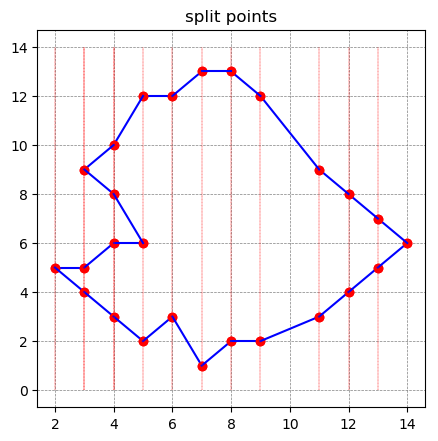

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def yblocks(xun=[],splits=[]):
    '''xun is list of unique x values; splits are split segments (x1,y1,x2,y2) in a polygon
    returns: {x:[(y1,y2),...]}'''
    xdict ={}
    for i in range(len(xun)-1):
        xl=xun[i]
        xdict[xl]=[]
    xdict[xun[-1]]=[] #add last ite,
    for i in range(len(splits)):
        x1=splits[i][0]
        y1=splits[i][1]
        x2=splits[i][2]
        y2=splits[i][3]
        if y1<y2:
            xdict[x1].append((y1,y2))
        else:
            xdict[x1].append((y2,y1))
    return xdict

def polysegments(points_list):
    pp = points_list
    segs= []
    n = len(pp)-1 #the last point is also the first point.
    for i in range(n): #make lines from points
        x1=pp[i][0]
        x2=pp[i+1][0]
        y1=pp[i][1]
        y2=pp[i+1][1]
        #collect all x-s in a dictionary
        #undict[x1]=1
        #undict[x2]=1
        #arrange lines so first x-coordinate is less that second
        if x1<=x2:
            tt=(x1,y1,x2,y2)
        else:
            tt=(x2,y2,x1,y1)
        if tt not in segs:
            segs.append(tt)
    return segs

def splitsegments(segs,xun):
    '''splits segments in segs where vertical lines pass through x-values in xun.
    that is, at points {(x,0): x in xun}'''
    ttt=[] # to hold all split lines
    for i in range(len(hl)):#split lines
        x1=segs[i][0]
        y1=segs[i][1]
        x2=segs[i][2]
        y2=segs[i][3]
        li=xun.index(x1)
        hi=xun.index(x2)
        nn=hi-li
        if nn<2 : #difference 0/1 means no split
            ttt.append([x1,y1,x2,y2])
        else: #chopping necessary
            yc=y1
            for j in range(li,hi):
                xc=xun[j]
                xn=xun[j+1]
                if xn < x2:
                    y=float(y2-y1)/(x2-x1)*(xn-x1)+y1
                    yn=int(round(y))
                    ttt.append([xc,yc,xn,yn])
                    yc=yn
                elif xn==x2: #last one
                    ttt.append([xc,yc,xn,y2])
            #end for
    #end for
    return ttt


poly1 = [(5, 6), (2, 5), (4, 3), (5, 2), (6, 3), (7, 1), (9, 2), (11, 3), (13, 5), (14, 6), (13, 7), 
         (12, 8), (11, 9), (9, 12), (8, 13), (5, 12), (4, 10), (3, 9), (5, 6)]
poly2 = [(11,9),(10,8.5), (9.5,8),(9,7),(8,7.5),
             (6,8),(4,9),(7,6), (6,5),(7,4),(9,5),(8,3),(12,1),(14,2),(15,1),(16,2),(17,4),(15,6),
             (14,4),(11,5),(13,7),(11,9)]
pp = poly1
segs= polysegments(pp)
xlist = [[t[0],t[2]] for t in segs]
xlist = [x for sublist in xlist for x in sublist]
xun = list(set(xlist))

splitsegs=splitsegments(segs,xun) # to hold all split lines
yblocks_onx = yblocks(xun=xun,splits=splitsegs)

#graphing
fig= plt.figure(1, figsize=(5,5), dpi=100)
ax = fig.add_subplot(111)
for split in splitsegs:
    ax.plot([split[0],split[2]],[split[1],split[3]],'o',c='red')
    ax.plot([split[0],split[2]],[split[1],split[3]],'-',c='blue')
    ax.plot([split[0],split[0]],[0,14],'--',c='red',linewidth=0.2)

ax.set_title('split points')
ax.grid(color='grey', linestyle='--', linewidth=.5)
plt.show()


In [10]:
import datetime
import hashlib
import dlsbuilder as DLSB
reload(DLSB)
import DataSources as mydatasource
import sys
import collections
reload(mydatasource)

print xdict
print
keys = sorted(xdict.keys())
keys = map(int, keys)
print keys
#grids=[]
#for i in range(len(keys)-1):
    #key,nkey = keys[i],keys[i+1]
    #grids.append(dlsObj.makedoc(xdict,key,nkey))
    
#key,nkey = keys[-1], keys[0] #last wrap up.
#grids.append(dlsObj.makedoc(xdict,key,nkey))    
#mapgridid=mapgrids.insert_many(grids)

##
dlsObj = DLS()
cid = dlsObj.Init()
t = 0 #0-> dict, 1-> LUT
cur_pkey = pkey1 = keys[0]
dlsObj.InsertFirstKey(cid,pkey1,1)

#for key in keys[1:2]:#exclude first, already inserted.
#dlsObj.InsertKey(cid,cur_pkey, key)
childcid = dlsObj.CreateCollection(cid, cur_pkey) #parent is cid, key is pkey1
dlsObj.InsertFirstKey(childcid,int(xdict[cur_pkey][0][0]), 1) #it puts value of key to 0, see S.val=0 in function. !!!!
cur_ckey = int(xdict[cur_pkey][0][0]) #current child key, tuple item

for tup in xdict[cur_pkey][1:3]: #all other tuples
    dlsObj.InsertKey(childcid,cur_ckey,int(tup[0]))
    cur_ckey = int(tup[0])

#cur_pkey = key
print dlsObj.Get2LevelHashes()
print len(GD)
#curr_key = firstKey
#for newkey in keys[1:]:
    #dlsObj.InsertKey(cid,curr_key,newkey)
    #curr_key = newkey
#print("InsertKey"),GD

[u'admin', u'dlsdb', u'local', u'test', u'test2']
len of features_names 3
{1.0: [(0.0, 1.0), (1.0, 3.0), (3.0, 5.0)], 2.0: [(4.0, 5.0), (5.0, 6.0), (0.0, 1.0)], 3.0: [(4.0, 4.0), (6.0, 8.0), (1.0, 1.0)], 4.0: [(3.0, 4.0), (8.0, 9.0), (1.0, 3.0)], 5.0: [(3.0, 3.0), (9.0, 10.0), (2.0, 3.0)], 6.0: [(3.0, 3.0), (10.0, 10.0), (1.0, 2.0)], 7.0: [(3.0, 4.0), (10.0, 10.0), (1.0, 1.0)], 10.0: [(4.0, 4.0), (9.0, 10.0), (1.0, 2.0)], 11.0: [(2.0, 4.0), (2.0, 2.0), (7.0, 9.0), (2.0, 4.0)], 13.0: [(2.0, 7.0)]}

[1, 2, 3, 4, 5, 6, 7, 10, 11, 13]
recursive 3b191fed 9a5bd9ea
updating hashes. 3a3d69a6 0 0 f2b25ad5 01a46586
updating hashes. 8322ca79 0 0 9a5bd9ea 0bd9e5cd
recursive 3b191fed 0bd9e5cd
updating hashes. 3a3d69a6 0 0 01a46586 b0f9e9e1
updating hashes. 8322ca79 1 1 3b456cd3 d907b958
recursive 3b191fed 2616dd90
updating hashes. 3a3d69a6 0 0 b0f9e9e1 6fdb6c62
['2616dd90', '88406e6a', 'd907b958', 'c4ff322e', 'a0a6d95a']
12


In [18]:
db.collection_names(include_system_collections=False) #list all the collections in a database

[u'test']